<a href="https://colab.research.google.com/github/Francesco0101/Computer-Vision-Project-on-Ground-To-Aerial-Matching/blob/main/CV_project_on_Cross_image_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [2]:
%%capture
!pip install gdown
!pip install rarfile
!pip install datasets opencv-contrib-python opencv-python ipywidgets scipy
!pip install pytorch_lightning
!pip install transformers torch pillow matplotlib

In [3]:
import gdown
import zipfile
import os
from google.colab.patches import cv2_imshow #rimuovere se online
import cv2
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pytorch_lightning as pl
from torch.utils.data import random_split
import logging
from collections import OrderedDict
import torchvision
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from torch import optim
from torch.utils.data.distributed import DistributedSampler
from pytorch_lightning.callbacks.progress import RichProgressBar
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, Mask2FormerForUniversalSegmentation

In [ ]:
torch.set_float32_matmul_precision('medium') # solo in locale

#University Dataset da cambiare

In [ ]:
!wget -O file.zip 'https://drive.google.com/file/d/17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_/view?usp=sharing' #Download dataset


In [ ]:

# Percorso del file zip
file_zip = "dataset.zip"

# Percorso di destinazione per l'estrazione
percorso_estrazione = "/content"

# Estrai il file zip
with zipfile.ZipFile(file_zip, 'r') as zip_ref:
    zip_ref.extractall(percorso_estrazione)

# Mostra i file estratti
print("File estratti in:", percorso_estrazione)
print("Elenco dei file estratti:")
for file in os.listdir(percorso_estrazione):
    print(file)

#CVUSA Dataset

To load directly without drive

In [ ]:
"""

!pip install rarfile
!gdown --id 17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_

"""

'\n\n!pip install rarfile\n!gdown --id 17W9VEPMneRlb6igtSxa--Xh4fSZs3RS_\n\n'

In [ ]:
# import rarfile
# import os

# # Percorso del file RAR
# file_rar = "/content/drive/MyDrive/CV/CVUSA_subset.rar"

# # Directory di destinazione per l'estrazione
# extract_path = "/content/CVUSA_subset"

# # Estrarre il file RAR
# with rarfile.RarFile(file_rar, 'r') as rar:
#     # Crea la directory di destinazione se non esiste
#     os.makedirs(extract_path, exist_ok=True)
#     # Estrai tutto nella directory di destinazione
#     rar.extractall(extract_path)

# print("Estrazione completata.")

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


##Needed Paths

In [5]:
# Percorsi delle directory
import re
#Francesco
bingmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/bingmap'
streetview_dir = '/content/drive/MyDrive/CV/CVUSA_subset/streetview'
cvusa_dir = '/content/drive/MyDrive/CV/CVUSA_subset'
csv_path = '/content/drive/MyDrive/CV/CVUSA_subset/file_paths.csv'
bingmap_depth_dir = '/content/drive/MyDrive/CV/CVUSA_subset/depth/bingmap'
streetview_depth_dir = '/content/drive/MyDrive/CV/CVUSA_subset/depth/streetview'
bingmap_segmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/segmap_new/bingmap'
streetview_segmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/segmap_new/streetview'
bingmap_sift_dir = '/content/drive/MyDrive/CV/CVUSA_subset/sift/bingmap'
streetview_sift_dir = '/content/drive/MyDrive/CV/CVUSA_subset/sift/streetview'
#Simone Local
# bingmap_dir = 'CVUSA_subset/bingmap'
# streetview_dir = 'CVUSA_subset/streetview'
# bingmap_sift_dir = 'CVUSA_subset/sift/bingmap'
# streetview_sift_dir = 'CVUSA_subset/sift/streetview'
# cvusa_dir = 'CVUSA_subset'
# csv_path = 'CVUSA_subset/file_paths.csv'
# bingmap_depth_dir = 'CVUSA_subset/depth/bingmap'
# streetview_depth_dir = 'CVUSA_subset/depth/streetview'
# bingmap_segmap_dir = 'CVUSA_subset/segmap_new/bingmap'
# streetview_segmap_dir = 'CVUSA_subset/segmap_new/streetview'


In [ ]:
# use in order to change positions of csv file
# import csv

# # Define input and output file paths
# input_csv = 'file_paths.csv'
# output_csv = 'updated_output_file.csv'

# # Prepend this prefix to each sample path
# prefix = "drive/MyDrive/CV"

# # Open input and output files
# with open(input_csv, 'r') as csvfile, open(output_csv, 'w', newline='') as outfile:
#     reader = csv.reader(csvfile)
#     writer = csv.writer(outfile)

#     # Iterate over each row in the input CSV
#     for row in reader:
#         updated_row = []
#         for col in row:
#             updated_col = f"{prefix}/{col}"
#             updated_row.append(updated_col)
#         writer.writerow(updated_row)

# print(f"Updated CSV file written to {output_csv}")


##SIFT

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# Definisci le liste per salvare i descrittori
Aerial_sift = []
Ground_sift = []

def extract_sift_descriptor(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()

    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
        return descriptors
    else:
        print("No descriptors found.")
        return None

# Esempio di utilizzo per estrarre e salvare i descrittori SIFT

for file in tqdm(bingmap_files):
    if file.endswith(".png"):
        image_path = os.path.join(bingmap_dir, file)
        sift_descriptor = extract_sift_descriptor(image_path)
        if sift_descriptor is not None:
            Aerial_sift.append(sift_descriptor)
            # Salva i descrittori nel file npy
            np.savez_compressed(f"drive/MyDrive/CVUSA_subset/sift/bingmap/sift_descriptors_{file[:-4]}.npz", sift_descriptor)

for file in tqdm(streetview_files):
    if file.endswith(".jpg"):
        image_path = os.path.join(streetview_dir, file)
        sift_descriptor = extract_sift_descriptor(image_path)
        if sift_descriptor is not None:
            Aerial_sift.append(sift_descriptor)
            # Salva i descrittori nel file npy
            np.savez_compressed(f"drive/MyDrive/CVUSA_subset/sift/streetview/sift_descriptors_{file[:-4]}.npz", sift_descriptor)



  0%|          | 12/8862 [00:03<40:13,  3.67it/s]


KeyboardInterrupt: 

In [ ]:
# import numpy as np

# # Esempio di caricamento dei descrittori SIFT da un file .npz
# file_path = "drive/MyDrive/CVUSA_subset/sift/bingmap/sift_descriptors_input0000008.npz"

# # Carica il file .npz
# data = np.load(file_path)

# # Estrai i descrittori
# sift_descriptors = data['arr_0']  # La chiave 'arr_0' è il nome predefinito per l'array salvato

# print(sift_descriptors)

[[ 7.  0.  0. ...  8.  0.  0.]
 [ 0.  0.  0. ... 22.  7. 36.]
 [ 0.  1.  5. ...  0. 18. 76.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [95. 21.  4. ...  8.  1.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [ ]:
for file in tqdm(streetview_files):
    if file.endswith(".jpg"):
        image_path = os.path.join(streetview_dir, file)
        sift_descriptor = extract_sift_descriptor(image_path)
        if sift_descriptor is not None:
            Aerial_sift.append(sift_descriptor)
            # Salva i descrittori nel file npy
            np.save(f"/sift/streetview/sift_descriptors_{file[:-4]}.npy", sift_descriptor)
            # print(f"Saved SIFT descriptors for {file}")

 75%|██████████████████████████████████████████████████████████▍                   | 6644/8862 [11:15<03:07, 11.84it/s]

No descriptors found.


100%|██████████████████████████████████████████████████████████████████████████████| 8862/8862 [15:26<00:00,  9.56it/s]


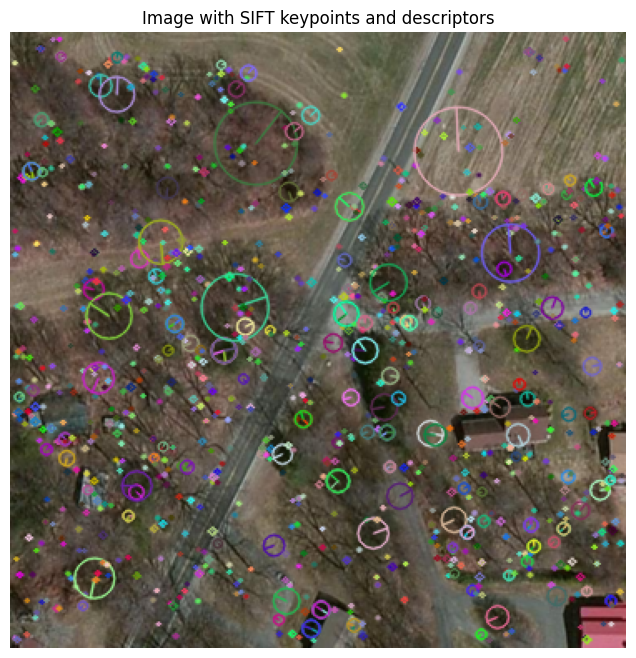

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Funzione per caricare l'immagine con keypoints e descrittori SIFT sovrapposti
def visualize_sift(image_path, sift_descriptor_path):
    # Carica l'immagine originale
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converti da BGR (OpenCV) a RGB (Matplotlib)

    # Carica i descrittori SIFT dal file .npy
    sift_descriptor = np.load(sift_descriptor_path)

    # Crea l'oggetto SIFT
    sift = cv2.SIFT_create()

    # Trova keypoints e calcola i descrittori
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Disegna i keypoints e i descrittori SIFT sull'immagine
    image_with_sift = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Visualizza l'immagine con i keypoints e i descrittori sovrapposti
    plt.figure(figsize=(10, 8))
    plt.imshow(image_with_sift)
    plt.title('Image with SIFT keypoints and descriptors')
    plt.axis('off')
    plt.show()

# Esempio di utilizzo
image_path = "/CVUSA_subset/bingmap/input0000008.png"
sift_descriptor_path = "/sift/bingmap/sift_descriptors_input0000008.npy"

visualize_sift(image_path, sift_descriptor_path)


In [ ]:
import numpy as np

# Esempio di caricamento di un descriptor SIFT da un file .npy
filename = "/sift/bingmap/sift_descriptors_input0000008.npy"  # Assicurati di specificare il percorso completo se non è nello stesso script

# Carica il descriptor SIFT dal file .npy
sift_descriptor = np.load(filename)

# Ora puoi utilizzare il descriptor SIFT per qualsiasi operazione desideri
print("Shape of loaded descriptor:", sift_descriptor.shape)
print("Example of loaded descriptor:", sift_descriptor[:10])  # Esempio di stampa dei primi 10 elementi del descriptor

Shape of loaded descriptor: (1143, 128)
Example of loaded descriptor: [[ 7.  0.  0. ...  8.  0.  0.]
 [ 0.  0.  0. ... 22.  7. 36.]
 [ 0.  1.  5. ...  0. 18. 76.]
 ...
 [82. 35.  9. ...  3.  5.  0.]
 [ 6. 13.  2. ... 53.  7.  3.]
 [33. 31. 27. ... 28. 78. 51.]]


##  Depth and Segmap


In [ ]:
depth_image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")

# Load segmentation model
seg_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-ade-semantic")
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-ade-semantic")

In [ ]:
# Define directories
bingmap_dir = '/CVUSA_subset/bingmap'
streetview_dir = '/CVUSA_subset/streetview'

# Create output directories
depth_aerial_dir = '/CVUSA_subset/depth_aerial'
seg_aerial_dir = '/CVUSA_subset/seg_aerial'
depth_ground_dir = '/CVUSA_subset/depth_ground'
seg_ground_dir = '/CVUSA_subset/seg_ground'

os.makedirs(depth_aerial_dir, exist_ok=True)
os.makedirs(seg_aerial_dir, exist_ok=True)
os.makedirs(depth_ground_dir, exist_ok=True)
os.makedirs(seg_ground_dir, exist_ok=True)

# List files in each directory
bingmap_files = [os.path.join(bingmap_dir, f) for f in os.listdir(bingmap_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
streetview_files = [os.path.join(streetview_dir, f) for f in os.listdir(streetview_dir) if f.endswith(('png', 'jpg', 'jpeg'))]



def process_image(image_path, depth_output_dir, seg_output_dir):
    image = Image.open(image_path)

    # Process depth estimation
    depth_inputs = depth_image_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        depth_outputs = depth_model(**depth_inputs)
        predicted_depth = depth_outputs.predicted_depth
        depth_prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()
    depth_output_path = os.path.join(depth_output_dir, os.path.basename(image_path))
    depth_image = Image.fromarray((depth_prediction * 255 / depth_prediction.max()).astype('uint8'))
    depth_image.save(depth_output_path)

    # Process segmentation
    seg_inputs = seg_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        seg_outputs = seg_model(**seg_inputs)
    predicted_segmentation = seg_processor.post_process_semantic_segmentation(seg_outputs, target_sizes=[image.size[::-1]])[0]
    seg_output_path = os.path.join(seg_output_dir, os.path.basename(image_path))
    seg_image = Image.fromarray(predicted_segmentation.numpy().astype('uint8'))
    seg_image.save(seg_output_path)

In [ ]:
for image_path in tqdm(bingmap_files):
    process_image(image_path, depth_aerial_dir, seg_aerial_dir)

In [ ]:
for image_path in tqdm(streetview_files):
    process_image(image_path, depth_ground_dir, seg_ground_dir)

In [ ]:
# Load images
image = Image.open("/CVUSA_subset/depth_aerial/input0000068.png")
image_seg = Image.open("/CVUSA_subset/seg_aerial/input0000068.png")
image_og = Image.open("/CVUSA_subset/bingmap/input0000068.png")

# Create a figure with a specified size
plt.figure(figsize=(18, 6))

# Display the original image in the first subplot
plt.subplot(1, 3, 1)
plt.imshow(image_og,  cmap='gnuplot')
plt.title('Original Image')
plt.axis('off')

# Display the depth aerial image in the second subplot
plt.subplot(1, 3, 2)
plt.imshow(image,  cmap='gnuplot')
plt.title('Depth Aerial')
plt.axis('off')

# Display the segmented aerial image in the third subplot
plt.subplot(1, 3, 3)
plt.imshow(image_seg, cmap='Red')
plt.title('Segmented Aerial')
plt.axis('off')

# Show the plot
plt.show()


##CSV creation

In [5]:
import os
import re
import csv

# Function to extract numeric identifier from filenames
def extract_identifier(filename):
    match = re.search(r'\d+', filename)
    return match.group() if match else None

# Read files from directories
bingmap_files = sorted(os.listdir(bingmap_dir))
streetview_files = sorted(os.listdir(streetview_dir))
bingmap_sift_files = sorted(os.listdir(bingmap_sift_dir))
streetview_sift_files = sorted(os.listdir(streetview_sift_dir))
streetview_depth_files = sorted(os.listdir(streetview_depth_dir))
bingmap_depth_files = sorted(os.listdir(bingmap_depth_dir))
streetview_segmap_files = sorted(os.listdir(streetview_segmap_dir))
bingmap_segmap_files = sorted(os.listdir(bingmap_segmap_dir))

# Print the number of files found in each directory
print(len(bingmap_files))
print(len(streetview_files))
print(len(bingmap_sift_files))
print(len(streetview_sift_files))
print(len(streetview_depth_files))
print(len(bingmap_depth_files))
print(len(streetview_segmap_files))
print(len(bingmap_segmap_files))

# Create dictionaries to map identifiers to filenames
bingmap_dict = {extract_identifier(f): f for f in bingmap_files}
streetview_dict = {extract_identifier(f): f for f in streetview_files}
bingmap_sift_dict = {extract_identifier(f): f for f in bingmap_sift_files}
streetview_sift_dict = {extract_identifier(f): f for f in streetview_sift_files}
streetview_depth_dict = {extract_identifier(f): f for f in streetview_depth_files}
bingmap_depth_dict = {extract_identifier(f): f for f in bingmap_depth_files}
streetview_segmap_dict = {extract_identifier(f): f for f in streetview_segmap_files}
bingmap_segmap_dict = {extract_identifier(f): f for f in bingmap_segmap_files}

# Find all identifiers
all_identifiers = set(bingmap_dict.keys()).union(
    streetview_dict.keys(),
    bingmap_sift_dict.keys(),
    streetview_sift_dict.keys(),
    streetview_depth_dict.keys(),
    bingmap_depth_dict.keys(),
    streetview_segmap_dict.keys(),
    bingmap_segmap_dict.keys()
)

# Write file paths to CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    for identifier in all_identifiers:
        bingmap_file = bingmap_dict.get(identifier, "None")
        streetview_file = streetview_dict.get(identifier, "None")
        bingmap_sift_file = bingmap_sift_dict.get(identifier, "None")
        streetview_sift_file = streetview_sift_dict.get(identifier, "None")
        streetview_depth_file = streetview_depth_dict.get(identifier, "None")
        bingmap_depth_file = bingmap_depth_dict.get(identifier, "None")
        streetview_segmap_file = streetview_segmap_dict.get(identifier, "None")
        bingmap_segmap_file = bingmap_segmap_dict.get(identifier, "None")

        bingmap_path = f"{bingmap_dir}/{bingmap_file}" if bingmap_file != "None" else "None"
        streetview_path = f"{streetview_dir}/{streetview_file}" if streetview_file != "None" else "None"
        bingmap_sift_path = f"{bingmap_sift_dir}/{bingmap_sift_file}" if bingmap_sift_file != "None" else "None"
        streetview_sift_path = f"{streetview_sift_dir}/{streetview_sift_file}" if streetview_sift_file != "None" else "None"
        bingmap_depth_path = f"{bingmap_depth_dir}/{bingmap_depth_file}" if bingmap_depth_file != "None" else "None"
        streetview_depth_path = f"{streetview_depth_dir}/{streetview_depth_file}" if streetview_depth_file != "None" else "None"
        bingmap_segmap_path = f"{bingmap_segmap_dir}/{bingmap_segmap_file}" if bingmap_segmap_file != "None" else "None"
        streetview_segmap_path = f"{streetview_segmap_dir}/{streetview_segmap_file}" if streetview_segmap_file != "None" else "None"

        writer.writerow([bingmap_path, streetview_path, bingmap_sift_path, streetview_sift_path, streetview_depth_path, bingmap_depth_path, streetview_segmap_path, bingmap_segmap_path])

print(f"CSV creato con successo in {csv_path}")



8862
8862
8855
8861
8862
8862
8862
8862
CSV creato con successo in /content/drive/MyDrive/CV/CVUSA_subset/file_paths.csv


# Dataset

In [6]:
class CVUSADatasetPath(Dataset):
    def __init__(self, cvusa_dir, directory):
        self.directory = directory
        self.cvusa_dir = cvusa_dir
        self.aerial_paths = []
        self.ground_paths = []
        self.aerial_sift_paths = []
        self.ground_sift_paths = []
        self.aerial_depth_paths = []
        self.ground_depth_paths = []
        self.aerial_segmap_paths = []
        self.ground_segmap_paths = []

        with open(self.directory, mode='r') as file:
          csv_reader = csv.reader(file, delimiter=',')
          for row in csv_reader:
              aerial_path = row[0]
              ground_path = row[1]
              aerial_sift_path = row[2]
              ground_sift_path = row[3]
              aerial_depth_path = row[4]
              ground_depth_path = row[5]
              aerial_segmap_path = row[6]
              ground_segmap_path = row[7]

              self.aerial_paths.append(aerial_path)
              self.ground_paths.append(ground_path)
              self.aerial_sift_paths.append(aerial_sift_path)
              self.ground_sift_paths.append(ground_sift_path)
              self.aerial_depth_paths.append(aerial_depth_path)
              self.ground_depth_paths.append(ground_depth_path)
              self.aerial_segmap_paths.append(aerial_segmap_path)
              self.ground_segmap_paths.append(ground_segmap_path)




    def __len__(self):
        return len(self.aerial_paths) # any image path is good

    def __getitem__(self, idx):
        return self.ground_paths[idx], self.aerial_paths[idx], self.ground_sift_paths[idx], self.aerial_sift_paths[idx], self.ground_depth_paths[idx], self.aerial_depth_paths[idx], self.ground_segmap_paths[idx], self.aerial_segmap_paths[idx]

In [7]:
class CVUSADataset(pl.LightningDataModule):
    def __init__(self, cvusa_dir, directory, batch_size=32, transform = True):
        super().__init__()
        self.batch_size = batch_size
        self.cvusa_dir = cvusa_dir
        self.directory = directory
        self.transformation = transform

    def setup(self, stage=None):
        self.dataset = CVUSADatasetPath(self.cvusa_dir, self.directory)
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(self.dataset, [0.8, 0.1, 0.1])

    def transform(self, set_type):
      transform = None
      if self.transformation == False:
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
      elif set_type == 'train':
        transform = transforms.Compose([
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
        ])
      else:
        transform = transforms.Compose([
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
        ])
      return transform

    def load_sift(self, paths):
        sifts = []
        max_length = 0

        # First pass: determine the maximum length
        for i in range(len(paths)):
          if paths[i] != "None":
            sift = np.load(paths[i])
            sift = sift["arr_0"].astype(np.float32)
            current_count = len(sift) # rimosso quando avro le feature effettivamente
            if current_count > 500:
              sift = sift[np.random.choice(current_count, 500, replace=False)]
            elif current_count < 500:
              add = np.random.choice(current_count, 500 - current_count, replace = True)
              sift = np.vstack((sift, sift[add]))
          else:
            sift = np.zeros((500, 128), dtype=np.float32)  # Creating a max_length x 128 zero array as a placeholder with float32

          sift_tensor = torch.from_numpy(sift)
          sifts.append(sift_tensor)
        sifts = torch.stack(sifts)

        # # Second pass: load and pad the tensors
        # for i in range(len(paths)):
        #     if paths[i] != "None":
        #         sift = np.load(paths[i]).astype(np.float32)  # Convert to float32
        #     else:
        #         sift = np.zeros((max_length, 128), dtype=np.float32)  # Creating a max_length x 128 zero array as a placeholder with float32
        #   sift_tensor = torch.from_numpy(sift)

        #     # Padding the tensor to the max_length
        #     pad_size = max_length - sift_tensor.shape[0]
        #     if pad_size > 0:
        #         padding = torch.zeros((pad_size, 128), dtype=torch.float32)  # Ensure padding is float32
        #         sift_tensor = torch.cat((sift_tensor, padding), dim=0)

        #    sifts.append(sift_tensor)

        # Stack the sifts and reshape to have 3 channels
        # sifts = torch.stack(sifts)
        # sifts = sifts.unsqueeze(1).repeat(1, 3, 1, 1)  # Add channel dimension and repeat it 3 times
        return sifts
        # return sifts.to('cuda')

    def load_images(self, paths, set_type):
      images = []
      idx = []
      for i in range(len(paths)):
        img = cv2.imread(paths[i])
        img = Image.fromarray(img)
        img = self.transform(set_type)(img)
        images.append(img)
        idx.append(paths[i])
      images = torch.stack(images)
      return images
      # return images.to('cuda')

    def collate_fn_train(self, batch):
      return self.collate_fn(batch, 'train')

    def collate_fn_val(self, batch):
      return self.collate_fn(batch, 'val')

    def collate_fn(self, batch, set_type):
      ground_paths, aerial_paths, ground_sift_paths, aerial_sift_paths, ground_depth_paths, aerial_depth_paths, ground_segmap_paths, aerial_segmap_paths = zip(*batch)
      ground_images = self.load_images(ground_paths, set_type)
      aerial_images = self.load_images(aerial_paths, set_type)
      ground_sift = self.load_sift(ground_sift_paths)
      aerial_sift = self.load_sift(aerial_sift_paths)
      ground_depth = self.load_images(ground_depth_paths, 'val')
      aerial_depth = self.load_images(aerial_depth_paths, 'val')
      ground_segmap = self.load_images(ground_segmap_paths, 'val')
      aerial_segmap = self.load_images(aerial_segmap_paths, 'val')

      return ground_images, aerial_images, ground_sift, aerial_sift, ground_depth, aerial_depth, ground_segmap, aerial_segmap

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, collate_fn = self.collate_fn_train) # no per locale, 2 per colab

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, collate_fn = self.collate_fn_val) # no per locale, 2 per colab

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, collate_fn = self.collate_fn_val) # no per locale, 2 per colab

#Siamese Branches

###VGG

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class SiameseNetworkVGG(nn.Module):
    def __init__(self):
        super(SiameseNetworkVGG, self).__init__()
        # Load the pretrained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        self.vgg16_features = vgg16.features
        # print("features: ", vgg16.features)  #feature vgg

        # Freeze the parameters of all layers except the last block
        for param in self.vgg16_features[:24].parameters():
            param.requires_grad = False


        self.fc1 = nn.Linear(512 * 7 * 7, 512)  # Adjust input size based on VGG16 output (n°feature maps * (img size / 2^num max pooling)^2)
        self.fc2 = nn.Linear(512, 256)

        self.fc1_sift = nn.Linear(500 * 128, 256)

    def forward_one(self, x, sift_type= False):
        if sift_type == True:
          #print("size: ", x.size())
          x = x.view(x.size()[0], -1)
          x = self.fc1_sift(x)
        else:
          #print("x prima di vgg: ", x.size())
          x = self.vgg16_features(x)
          # print("x: ", x.size())
          x = F.adaptive_avg_pool2d(x, (7, 7))    #adaptive to have flexibility on input size (the first fc layer will have feature maps of dimension 7x7)
          # print("x dopo avg_pool: ",x.size())
          x = x.view(x.size()[0], -1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
        return x

    def forward_combined(self, input1, input2, feature_type ='NOSIFT'):
        grd_global = self.forward_one(input1)
        sat_global = None
        if feature_type == "SIFT":
          sat_global = self.forward_one(input2, sift_type = True)
        else:
          sat_global = self.forward_one(input2)
        return grd_global, sat_global

    def forward_combined_3(self, input1, input2, input3, feature_type = 'NOSIFT'):
        grd_global = self.forward_one(input1)
        sat_global = None
        var_global = self.forward_one(input3)

        if feature_type == "SIFT":
          sat_global = self.forward_one(input2, sift_type = True)
        else:
          sat_global = self.forward_one(input2)
        return grd_global, sat_global , var_global


    def forward_combined_4(self, input1, input2, input3, input4, feature_type='NOSIFT'):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global2 = None
        sat_global2 = None
        if feature_type == "SIFT":
          grd_global2 = self.forward_one(input3, sift_type = True)
          sat_global2 = self.forward_one(input4, sift_type = True)
        else:
          grd_global2 = self.forward_one(input3)
          sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2

    def forward_combined_6(self, input1, input2, input3, input4, input5, input6, feature_type='NOSIFT'):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global2 = None
        sat_global2 = None
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        if feature_type == "SIFT":
          grd_global2 = self.forward_one(input3, sift_type = True)
          sat_global2 = self.forward_one(input4, sift_type = True)
        else:
          grd_global2 = self.forward_one(input3)
          sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3

    def forward_combined_8(self, input1, input2, input3, input4, input5, input6, input7, input8):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3, sift_type = True)
        sat_global2 = self.forward_one(input4, sift_type = True)
        grd_global4 = self.forward_one(input7)
        sat_global4 = self.forward_one(input8)

        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3 , grd_global4, sat_global4

    def forward_combined_4_oct(self, input1, input2, input3, input4):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2, sift_type = True)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)

        return grd_global, sat_global, grd_global2, sat_global2

##RESNET BRANCH

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class SiameseNetworkRESNET(nn.Module):
    def __init__(self):
        super(SiameseNetworkRESNET, self).__init__()

        # Load the pretrained ResNet-50 model with the best available weights
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Extract the feature extraction part of ResNet-50 (remove the last two layers)
        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])

        # Optionally freeze some of the ResNet layers
        for param in list(self.resnet_features.parameters())[:-3]:
            param.requires_grad = False

        # Define fully connected layers
        self.fc1 = nn.Linear(2048 * 7 * 7, 512)  # Adjust input size based on ResNet-50 output
        self.fc2 = nn.Linear(512, 256)

        self.fc1_sift = nn.Linear(500 * 128, 256)

    def forward_one(self, x, sift_type= False):
        if sift_type == True:
          #print("size: ", x.size())
          x = x.view(x.size()[0], -1)
          x = self.fc1_sift(x)
        else:
          x = self.resnet_features(x)
          x = F.adaptive_avg_pool2d(x, (7, 7))  # Ensure the correct input size to the fc1 layer
          x = x.view(x.size()[0], -1)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
        return x

    def forward_combined(self, input1, input2, feature_type = 'NOSIFT'):
        grd_global = self.forward_one(input1)
        sat_global = None
        if feature_type == "SIFT":
          sat_global = self.forward_one(input2, sift_type = True)
        else:
          sat_global = self.forward_one(input2)
        return grd_global, sat_global

    def forward_combined_3(self, input1, input2, input3, feature_type = 'NOSIFT'):
        grd_global = self.forward_one(input1)
        sat_global = None
        var_global = self.forward_one(input3)

        if feature_type == "SIFT":
          sat_global = self.forward_one(input2, sift_type = True)
        else:
          sat_global = self.forward_one(input2)
        return grd_global, sat_global , var_global

    def forward_combined_4(self, input1, input2, input3, input4, feature_type='NOSIFT'):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global2 = None
        sat_global2 = None
        if feature_type == "SIFT":
          grd_global2 = self.forward_one(input3, sift_type = True)
          sat_global2 = self.forward_one(input4, sift_type = True)
        else:
          grd_global2 = self.forward_one(input3)
          sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2

    def forward_combined_6(self, input1, input2, input3, input4, input5, input6, feature_type='NOSIFT'):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global2 = None
        sat_global2 = None
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        if feature_type == "SIFT":
          grd_global2 = self.forward_one(input3, sift_type = True)
          sat_global2 = self.forward_one(input4, sift_type = True)
        else:
          grd_global2 = self.forward_one(input3)
          sat_global2 = self.forward_one(input4)
        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3

    def forward_combined_8(self, input1, input2, input3, input4, input5, input6, input7, input8):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2)
        grd_global3 = self.forward_one(input5)
        sat_global3 = self.forward_one(input6)
        grd_global2 = self.forward_one(input3, sift_type = True)
        sat_global2 = self.forward_one(input4, sift_type = True)
        grd_global4 = self.forward_one(input7)
        sat_global4 = self.forward_one(input8)

        return grd_global, sat_global, grd_global2, sat_global2 , grd_global3, sat_global3 , grd_global4, sat_global4

    def forward_combined_4_oct(self, input1, input2, input3, input4):
        grd_global = self.forward_one(input1)
        sat_global = self.forward_one(input2, sift_type = True)
        grd_global2 = self.forward_one(input3)
        sat_global2 = self.forward_one(input4)

        return grd_global, sat_global, grd_global2, sat_global2

#LOSS AND VALIDATE

In [10]:
class SiameseLoss:
    def __init__(self, loss_weight=10.0):
        self.loss_weight = loss_weight

    def compute_loss(self, triplet_dist_g2s, triplet_dist_s2g, pair_n):
        loss_g2s = torch.sum(torch.log(1 + torch.exp(triplet_dist_g2s * self.loss_weight))) / pair_n
        loss_s2g = torch.sum(torch.log(1 + torch.exp(triplet_dist_s2g * self.loss_weight))) / pair_n
        loss = (loss_g2s + loss_s2g) / 2.0
        return loss

class ValidationMetrics:
    def __init__(self):
        pass

    @staticmethod
    def validate(grd_descriptor, sat_descriptor):
        accuracy = 0.0
        data_amount = 0.0
        dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))
        if (int(dist_array.shape[0] * 0.01) < 1 ):
          top1_percent = 1
        else:
          top1_percent = int(dist_array.shape[0] * 0.01)
        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            prediction = torch.sum(dist_array[:, i].cpu().lt(gt_dist.cpu()))
            if prediction < top1_percent:
                accuracy += 1.0
            data_amount += 1.0
        accuracy /= data_amount
        return accuracy

    @staticmethod
    def validate_topk(grd_descriptor, sat_descriptor, k):
        accuracy_topk = 0.0
        data_amount = 0.0
        dist_array = 2 - 2 * np.matmul(sat_descriptor.cpu(), np.transpose(grd_descriptor.cpu()))
        for i in range(dist_array.shape[0]):
            gt_dist = dist_array[i, i]
            sorted_indices = torch.argsort(dist_array[:, i])
            rank = torch.where(sorted_indices == i)[0].item()
            if rank < k:
                accuracy_topk += 1.0
            data_amount += 1.0
        accuracy_topk /= data_amount
        return accuracy_topk


# DUAL NETWORK (SIAMESE-LIKE OR NOT)

In [ ]:
class SiameseDualNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG", combined = True):
        super(SiameseDualNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined
        if branch == "VGG":
          if self.combined:
            self.model1 = SiameseNetworkVGG()
          else:
            self.model1 = SiameseNetworkVGG()
            self.model2 = SiameseNetworkVGG()
        elif branch == "RESNET":
          if self.combined:
            self.model1 = SiameseNetworkRESNET()
          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()

    #deve sempre essere uguale a quella definita in cvusadataset
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform


    def forward(self, ground, aerial):
        grd_global = None
        sat_global = None
        if self.combined:
          grd_global, sat_global = self.model1.forward_combined(ground, aerial)
        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)
        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):
      grd, sat, _ , _ , _, _, _, _= batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd ,sat)
      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):
        grd, sat, _ , _ , _, _, _, _= batch
        dist_g2s, dist_s2g, pair_n, grd_global , sat_global = self.forward(grd, sat)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):
        grd, sat, _ , _ , _, _, _, _= batch
        dist_g2s, dist_s2g, pair_n, grd_global, sat_global = self.forward(grd, sat)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_val}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:

seed_everything(42, workers=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='/content/drive/MyDrive/CV/CVUSA_subset/checkpointVGG/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [ ]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseDualNetworkLightning(branch="VGG", combined = True)
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 44.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 36.4 M                                                                                           
Non-trainable params: 7.6 M                                                                                        
Total params: 44.1 M                                                                                               
Total estimated model params size (MB): 176

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

In [ ]:
#print(model.search(data_module.dataset[1][0], data_module.dataset[:100][1], 10)) #da modificare perche la search e' fuori.

# QUAD NETWORK (SIAMESE-LIKE OR NOT)

In [ ]:
class SiameseQuadNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG", combined = 0, feature_type = 'SIFT'):
        super(SiameseQuadNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined
        self.feature_type = feature_type
        if branch == "VGG":
          if self.combined == 0:
            self.model1 = SiameseNetworkVGG()

          elif self.combined == 1:
            self.model1 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) ground
            self.model2 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) aerial
          else:
            self.model1 = SiameseNetworkVGG() # immagine ground
            self.model2 = SiameseNetworkVGG() # immagine aerial
            self.model3 = SiameseNetworkVGG() # sift, depth, segmap ground
            self.model4 = SiameseNetworkVGG() # sift, depth, segmap aerial
        elif branch == "RESNET":
          # guardare VGG
          if self.combined == 0:
            self.model1 = SiameseNetworkRESNET()

          elif self.combined == 1:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()

          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
            self.model3 = SiameseNetworkRESNET()
            self.model4 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()


    #deve sempre essere uguale a quella definita in cvusadataset (modificare quando si fa la search forse)
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform

    # da modificare alla fine
    def search(self, path, paths, n=5):
        images_search = []
        # Leggi e trasforma l'immagine di base
        img_base = cv2.imread(path)
        img_base = Image.fromarray(cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        img_base_tensor = self.transform()(img_base)
        img_base_tensor = img_base_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU

        # Leggi e trasforma le immagini di ricerca
        for img_path in paths:
            img = cv2.imread(img_path)
            img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            img_tensor = self.transform()(img)
            img_tensor = img_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU
            images_search.append(img_tensor)

        # Combina tutte le immagini di ricerca in un singolo tensore
        images_search = torch.cat(images_search)

        # Debug: Stampa per verificare le dimensioni dei tensori
        print(f"img_base_tensor shape: {img_base_tensor.shape}")
        print(f"images_search shape: {images_search.shape}")

        # Passa le immagini attraverso il modello
        grd_global, sat_global = self.model(img_base_tensor, images_search)

        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())

        # Trova le n immagini più vicine
        distances, indices = torch.topk(dist_matrix.squeeze(), n, largest=False)
        print("indices: ",indices)
        print("distances: ",distances)

        # Stampa l'immagine originale
        plt.figure(figsize=(5, 10 +n))  # Modifica delle dimensioni per una colonna lunga
        plt.subplot(n + 1, 1, 1)  # Una colonna, (n+1) righe
        plt.imshow(img_base)
        plt.title("Original Image")
        plt.axis('off')

        # Stampa le n immagini più vicine
        for i, idx in enumerate(indices.tolist(), start = 1):
            img_closest = cv2.imread(paths[idx])
            img_closest = cv2.cvtColor(img_closest, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            plt.subplot(n + 1, 1, i + 1)  # Una colonna, (n+1) righe
            title = f"Close image {idx} with distance {distances[i-1]:.2f}"
            plt.imshow(img_closest)
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Restituisci la matrice delle distanze e gli indici delle immagini più vicine
        return dist_matrix, indices.tolist()


    def forward(self, ground, aerial, feature_ground, feature_aerial):
        grd_global = None
        sat_global = None
        feat_aerial = None
        feat_ground = None
        if self.combined == 0:
          grd_global, sat_global, feat_ground, feat_aerial  = self.model1.forward_combined_4(ground, aerial, feature_ground, feature_aerial, self.feature_type)

        elif self.combined == 1:
          grd_global, feat_ground = self.model1.forward_combined(ground, feature_ground, self.feature_type)
          sat_global, feat_aerial = self.model2.forward_combined(aerial, feature_aerial, self.feature_type)

        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)
          if self.feature_type == 'SIFT':
            feat_ground = self.model3.forward_one(feature_ground, True)
            feat_aerial = self.model4.forward_one(feature_aerial, True)
          else:
            feat_ground = self.model3.forward_one(feature_ground)
            feat_aerial = self.model4.forward_one(feature_aerial)

        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        feat_ground = F.normalize(feat_ground, dim=1)
        feat_aerial = F.normalize(feat_aerial, dim=1)
        # Concatenazione delle caratteristiche
        grd_global = torch.cat((grd_global, feat_ground), dim=1)
        sat_global = torch.cat((sat_global, feat_aerial), dim=1)

        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):
      if self.feature_type == 'SIFT':
        grd, sat, feat_grd , feat_sat, _, _, _, _ = batch
      elif self.feature_type == 'DEPTH':
        grd, sat, _, _, feat_grd , feat_sat, _, _ = batch
      elif self.feature_type == 'SEGMAP':
        grd, sat, _, _, _, _, feat_grd , feat_sat = batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat)

      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):
        if self.feature_type == 'SIFT':
          grd, sat, feat_grd , feat_sat, _, _, _, _ = batch
        elif self.feature_type == 'DEPTH':
          grd, sat, _, _, feat_grd , feat_sat, _, _ = batch
        elif self.feature_type == 'SEGMAP':
          grd, sat, _, _, _, _, feat_grd , feat_sat = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):
        if self.feature_type == 'SIFT':
          grd, sat, feat_grd , feat_sat, _, _, _, _ = batch
        elif self.feature_type == 'DEPTH':
          grd, sat, _, _, feat_grd , feat_sat, _, _ = batch
        elif self.feature_type == 'SEGMAP':
          grd, sat, _, _, _, _, feat_grd , feat_sat = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_test = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_test, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_test}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [ ]:

seed_everything(42, workers=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='/content/drive/MyDrive/CV/CVUSA_subset/checkpointVGGQuad/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [ ]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseQuadNetworkLightning(branch="VGG", combined = 0, feature_type = 'DEPTH')
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 44.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 36.4 M                                                                                           
Non-trainable params: 7.6 M                                                                                        
Total params: 44.1 M                                                                                               
Total estimated model params size (MB): 176

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

# HEX NETWORK (SIAMESE-LIKE OR NOT)

In [19]:
class SiameseHexNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG", combined = 0, feature_type = 'SIFT' , feature2_type = "DEPTH"):
        super(SiameseHexNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined

        if feature2_type == "SIFT":
          self.feature_type = feature2_type
          self.feature2_type = feature_type
        else:
          self.feature_type = feature_type
          self.feature2_type = feature2_type



        if branch == "VGG":
          if self.combined == 0:
            self.model1 = SiameseNetworkVGG()

          elif self.combined == 1:
            self.model1 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) ground
            self.model2 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) aerial
          else:
            self.model1 = SiameseNetworkVGG() # immagine ground
            self.model2 = SiameseNetworkVGG() # immagine aerial
            self.model3 = SiameseNetworkVGG() # depth ground
            self.model4 = SiameseNetworkVGG() # depth aerial
            self.model5 = SiameseNetworkVGG() # seg ground
            self.model6 = SiameseNetworkVGG() # seg aerial
        elif branch == "RESNET":
          # guardare VGG
          if self.combined == 0:
            self.model1 = SiameseNetworkRESNET()

          elif self.combined == 1:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()

          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
            self.model3 = SiameseNetworkRESNET()
            self.model4 = SiameseNetworkRESNET()
            self.model5 = SiameseNetworkRESNET()
            self.model6 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()


    #deve sempre essere uguale a quella definita in cvusadataset (modificare quando si fa la search forse)
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform

    # da modificare alla fine
    def search(self, path, paths, n=5):
        images_search = []
        # Leggi e trasforma l'immagine di base
        img_base = cv2.imread(path)
        img_base = Image.fromarray(cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        img_base_tensor = self.transform()(img_base)
        img_base_tensor = img_base_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU

        # Leggi e trasforma le immagini di ricerca
        for img_path in paths:
            img = cv2.imread(img_path)
            img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            img_tensor = self.transform()(img)
            img_tensor = img_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU
            images_search.append(img_tensor)

        # Combina tutte le immagini di ricerca in un singolo tensore
        images_search = torch.cat(images_search)

        # Debug: Stampa per verificare le dimensioni dei tensori
        print(f"img_base_tensor shape: {img_base_tensor.shape}")
        print(f"images_search shape: {images_search.shape}")

        # Passa le immagini attraverso il modello
        grd_global, sat_global = self.model(img_base_tensor, images_search)

        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())

        # Trova le n immagini più vicine
        distances, indices = torch.topk(dist_matrix.squeeze(), n, largest=False)
        print("indices: ",indices)
        print("distances: ",distances)

        # Stampa l'immagine originale
        plt.figure(figsize=(5, 10 +n))  # Modifica delle dimensioni per una colonna lunga
        plt.subplot(n + 1, 1, 1)  # Una colonna, (n+1) righe
        plt.imshow(img_base)
        plt.title("Original Image")
        plt.axis('off')

        # Stampa le n immagini più vicine
        for i, idx in enumerate(indices.tolist(), start = 1):
            img_closest = cv2.imread(paths[idx])
            img_closest = cv2.cvtColor(img_closest, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            plt.subplot(n + 1, 1, i + 1)  # Una colonna, (n+1) righe
            title = f"Close image {idx} with distance {distances[i-1]:.2f}"
            plt.imshow(img_closest)
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Restituisci la matrice delle distanze e gli indici delle immagini più vicine
        return dist_matrix, indices.tolist()


    def forward(self, ground, aerial, f1_ground, f1_aerial , f2_ground , f2_aerial):
        grd_global = None
        sat_global = None
        feat1_aerial = None
        feat1_ground = None
        feat2_aerial = None
        feat2_ground = None
        if self.combined == 0:
          grd_global, sat_global, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial = self.model1.forward_combined_6(ground, aerial, f1_ground, f1_aerial, f2_ground, f2_aerial, self.feature_type)

        elif self.combined == 1:
          grd_global, feat1_ground , feat2_ground = self.model1.forward_combined_3(ground, f1_ground, f2_ground, self.feature_type)
          sat_global, feat1_aerial , feat2_aerial = self.model2.forward_combined_3(aerial, f1_aerial, f2_aerial,  self.feature_type)

        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)
          if self.feature_type == 'SIFT':
            feat1_ground = self.model3.forward_one(f1_ground, True)
            feat1_aerial = self.model4.forward_one(f1_aerial, True)
          else:
            feat1_ground = self.model3.forward_one(f1_ground)
            feat1_aerial = self.model4.forward_one(f1_aerial)
          feat2_ground = self.model5.forward_one(f2_ground)
          feat2_aerial = self.model6.forward_one(f2_aerial)

        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        feat1_ground = F.normalize(feat1_ground, dim=1)
        feat1_aerial = F.normalize(feat1_aerial, dim=1)
        feat2_ground = F.normalize(feat2_ground, dim=1)
        feat2_aerial = F.normalize(feat2_aerial, dim=1)
        # Concatenazione delle caratteristiche
        grd_global = torch.cat((grd_global, feat1_ground ,feat2_ground), dim=1)
        sat_global = torch.cat((sat_global, feat1_aerial, feat2_aerial), dim=1)

        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):

      if self.feature_type == "SIFT" and self.feature2_type == "DEPTH" or self.feature_type == "DEPTH" and self.feature2_type == "SIFT":
        grd, sat, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial, _, _ = batch

      elif self.feature_type == "SIFT" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "SIFT":
        grd, sat, feat1_ground, feat1_aerial, _, _, feat2_ground, feat2_aerial = batch

      elif self.feature_type == "DEPTH" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "DEPTH":
        grd, sat, _, _, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial = batch


      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial)

      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):

        if self.feature_type == "SIFT" and self.feature2_type == "DEPTH" or self.feature_type == "DEPTH" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial, _, _ = batch

        elif self.feature_type == "SIFT" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, _, _, feat2_ground, feat2_aerial = batch

        elif self.feature_type == "DEPTH" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "DEPTH":
          grd, sat, _, _, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial = batch


        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):

        if self.feature_type == "SIFT" and self.feature2_type == "DEPTH" or self.feature_type == "DEPTH" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial, _, _ = batch

        elif self.feature_type == "SIFT" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "SIFT":
          grd, sat, feat1_ground, feat1_aerial, _, _, feat2_ground, feat2_aerial = batch

        elif self.feature_type == "DEPTH" and self.feature2_type == "SEGMAP" or self.feature_type == "SEGMAP" and self.feature2_type == "DEPTH":
          grd, sat, _, _, feat1_ground, feat1_aerial, feat2_ground, feat2_aerial = batch


        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat1_ground, feat1_aerial , feat2_ground , feat2_aerial)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_test = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_test, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_test}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [20]:

seed_everything(42, workers=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='/content/drive/MyDrive/CV/CVUSA_subset/checkpointVGGQuad/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    # every_n_train_steps=2, # test
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [24]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseHexNetworkLightning(branch="RESNET", combined = 2, feature_type = 'DEPTH' , feature2_type = "SEGMAP")
trainer = pl.Trainer(
    val_check_interval=2,
    max_epochs=10,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.9MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkRESNET │ 91.4 M │ train │
│ 1 │ model2 │ SiameseNetworkRESNET │ 91.4 M │ train │
│ 2 │ model3 │ SiameseNetworkRESNET │ 91.4 M │ train │
│ 3 │ model4 │ SiameseNetworkRESNET │ 91.4 M │ train │
│ 4 │ model5 │ SiameseNetworkRESNET │ 91.4 M │ train │
│ 5 │ model6 │ SiameseNetworkRESNET │ 91.4 M │ train │
└───┴────────┴──────────────────────┴────────┴───────┘

Trainable params: 413 M                                                                                            
Non-trainable params: 134 M                                                                                        
Total params: 548 M                                                                                                
Total estimated model params size (MB): 2.2 K

Output()

# OCTA NETWORK (SIAMESE-LIKE OR NOT)

In [11]:
class SiameseOctaNetworkLightning(pl.LightningModule):
    def __init__(self, learning_rate=1e-3, branch = "VGG", combined = 0):
        super(SiameseOctaNetworkLightning, self).__init__()
        self.branch = branch
        self.combined = combined

        if branch == "VGG":
          if self.combined == 0:
            self.model1 = SiameseNetworkVGG()

          elif self.combined == 1:
            self.model1 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) ground
            self.model2 = SiameseNetworkVGG() # prende in input due cose (immagine + sift, depth, segmap) aerial
          else:
            self.model1 = SiameseNetworkVGG() # immagine ground
            self.model2 = SiameseNetworkVGG() # immagine aerial
            self.model3 = SiameseNetworkVGG() # siftground
            self.model4 = SiameseNetworkVGG() # siftaerial
            self.model5 = SiameseNetworkVGG() # depth ground
            self.model6 = SiameseNetworkVGG() # depth aerial
            self.model7 = SiameseNetworkVGG() # seg ground
            self.model8 = SiameseNetworkVGG() # seg aerial
        elif branch == "RESNET":
          # guardare VGG
          if self.combined == 0:
            self.model1 = SiameseNetworkRESNET()

          elif self.combined == 1:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()

          else:
            self.model1 = SiameseNetworkRESNET()
            self.model2 = SiameseNetworkRESNET()
            self.model3 = SiameseNetworkRESNET()
            self.model4 = SiameseNetworkRESNET()
            self.model5 = SiameseNetworkRESNET()
            self.model6 = SiameseNetworkRESNET()
            self.model7 = SiameseNetworkRESNET()
            self.model8 = SiameseNetworkRESNET()
        else:
          raise ValueError("Branch must be either 'VGG' or 'RESNET'")

        self.learning_rate = learning_rate
        self.loss_calculator = SiameseLoss()
        self.validator = ValidationMetrics()


    #deve sempre essere uguale a quella definita in cvusadataset (modificare quando si fa la search forse)
    def transform(self):
      transform = transforms.Compose([
          # transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
      ])

      return transform

    # da modificare alla fine
    def search(self, path, paths, n=5):
        images_search = []
        # Leggi e trasforma l'immagine di base
        img_base = cv2.imread(path)
        img_base = Image.fromarray(cv2.cvtColor(img_base, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        img_base_tensor = self.transform()(img_base)
        img_base_tensor = img_base_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU

        # Leggi e trasforma le immagini di ricerca
        for img_path in paths:
            img = cv2.imread(img_path)
            img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            img_tensor = self.transform()(img)
            img_tensor = img_tensor.unsqueeze(0).to(self.device)  # Aggiungi dimensione batch e sposta sulla GPU
            images_search.append(img_tensor)

        # Combina tutte le immagini di ricerca in un singolo tensore
        images_search = torch.cat(images_search)

        # Debug: Stampa per verificare le dimensioni dei tensori
        print(f"img_base_tensor shape: {img_base_tensor.shape}")
        print(f"images_search shape: {images_search.shape}")

        # Passa le immagini attraverso il modello
        grd_global, sat_global = self.model(img_base_tensor, images_search)

        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())

        # Trova le n immagini più vicine
        distances, indices = torch.topk(dist_matrix.squeeze(), n, largest=False)
        print("indices: ",indices)
        print("distances: ",distances)

        # Stampa l'immagine originale
        plt.figure(figsize=(5, 10 +n))  # Modifica delle dimensioni per una colonna lunga
        plt.subplot(n + 1, 1, 1)  # Una colonna, (n+1) righe
        plt.imshow(img_base)
        plt.title("Original Image")
        plt.axis('off')

        # Stampa le n immagini più vicine
        for i, idx in enumerate(indices.tolist(), start = 1):
            img_closest = cv2.imread(paths[idx])
            img_closest = cv2.cvtColor(img_closest, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            plt.subplot(n + 1, 1, i + 1)  # Una colonna, (n+1) righe
            title = f"Close image {idx} with distance {distances[i-1]:.2f}"
            plt.imshow(img_closest)
            plt.title(title)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Restituisci la matrice delle distanze e gli indici delle immagini più vicine
        return dist_matrix, indices.tolist()


    def forward(self, ground, aerial, feature_ground, feature_aerial, feature_ground_2 , feature_aerial_2, feature_ground_3 , feature_aerial_3):
        grd_global = None
        sat_global = None
        feat_aerial = None
        feat_ground = None
        feat_aerial_2 = None
        feat_ground_2 = None
        feat_aerial_3 = None
        feat_ground_3 = None

        if self.combined == 0:
          grd_global, sat_global, feat_ground, feat_aerial, feat_ground_2 , feat_aerial_2, feat_ground_3 , feat_aerial_3 = self.model1.forward_combined_8(ground, aerial, feature_ground, feature_aerial, feature_ground_2, feature_aerial_2, feature_ground_3, feature_aerial_3)

        elif self.combined == 1:
          grd_global, feat_ground ,feat_ground_2 , feat_ground_3 = self.model1.forward_combined_4_oct(ground, feature_ground, feature_ground_2, feature_ground_3)
          sat_global, feat_aerial, feat_aerial_2 , feat_aerial_3 = self.model2.forward_combined_4_oct(aerial, feature_aerial, feature_aerial_2, feature_aerial_3)

        else:
          grd_global  = self.model1.forward_one(ground)
          sat_global  = self.model2.forward_one(aerial)

          feat_ground = self.model3.forward_one(feature_ground, True)
          feat_aerial = self.model4.forward_one(feature_aerial, True)

          feat_ground_2 = self.model5.forward_one(feature_ground_2)
          feat_aerial_2 = self.model6.forward_one(feature_aerial_2)

          feat_ground_3 = self.model7.forward_one(feature_ground_3)
          feat_aerial_3 = self.model8.forward_one(feature_aerial_3)


        grd_global = F.normalize(grd_global, dim=1)
        sat_global = F.normalize(sat_global, dim=1)
        feat_ground = F.normalize(feat_ground, dim=1)
        feat_aerial = F.normalize(feat_aerial, dim=1)
        feat_ground_2 = F.normalize(feat_ground_2, dim=1)
        feat_aerial_2 = F.normalize(feat_aerial_2, dim=1)
        feat_ground_3 = F.normalize(feat_ground_3, dim=1)
        feat_aerial_3 = F.normalize(feat_aerial_3, dim=1)

        # Concatenazione delle caratteristiche
        grd_global = torch.cat((grd_global, feat_ground, feat_ground_2, feat_ground_3), dim=1)
        sat_global = torch.cat((sat_global, feat_aerial, feat_aerial_2, feat_aerial_3), dim=1)

        #print("grd_global: ", grd_global)
        #print("sat_global: ", sat_global)

        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        #print("dist_matrix: ",dist_matrix)
        pos_dist = torch.diag(dist_matrix)

        batch_size = sat_global.size(0)
        #print("batch_size: ",batch_size)

        pair_n = batch_size * (batch_size - 1.0)

        # ground to satellite
        triplet_dist_g2s = pos_dist - dist_matrix

        # satellite to ground
        triplet_dist_s2g = pos_dist.unsqueeze(1) - dist_matrix

        #print("triplet_dist_g2s: ", triplet_dist_g2s)
        #print("triplet_dist_s2g: ", triplet_dist_s2g)

        return triplet_dist_g2s, triplet_dist_s2g, pair_n, grd_global, sat_global

    def training_step(self, batch, batch_idx):

      grd, sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3 = batch
      # print("batch id: ", batch_idx)
      dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3)

      loss_train = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
      self.log('train_loss', loss_train, on_step=True, on_epoch=True, prog_bar=True )
      tqdm_dict = OrderedDict({"loss_train": loss_train})
      output = {"loss": loss_train, "progress_bar": tqdm_dict, "log": tqdm_dict}
      return output

    def validation_step(self, batch, batch_idx):

        grd, sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3 = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3)
        loss_val = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        # self.search(grd_global, sat_global, grd, sat, 2)
        accuracy_val = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_loss', loss_val, on_step=False, on_epoch=True, prog_bar=True )
        self.log('val_accuracy_top1percent', accuracy_val, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        output= {"val_loss": loss_val, "val_accuracy": accuracy_val}
        return output

    def test_step(self, batch, batch_idx):

        grd, sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3 = batch
        # print("batch id: ", batch_idx)
        dist_g2s , dist_s2g , pair_n , grd_global , sat_global = self.forward(grd , sat, feat_grd, feat_sat, feat_grd_2, feat_sat_2, feat_grd_3, feat_sat_3)
        loss_test = self.loss_calculator.compute_loss(dist_g2s, dist_s2g, pair_n)
        accuracy_test = self.validator.validate(grd_global, sat_global)
        accuracy_top1 = self.validator.validate_topk(grd_global, sat_global, 1)
        accuracy_top5 = self.validator.validate_topk(grd_global, sat_global, 5)
        accuracy_top10 = self.validator.validate_topk(grd_global, sat_global, 10)
        accuracy_top32 = self.validator.validate_topk(grd_global, sat_global, 32)
        self.log('batch_size', grd.shape[0], on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_loss', loss_test, on_step=False, on_epoch=True, prog_bar=True )
        self.log('test_accuracy_top1percent', accuracy_test, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top1', accuracy_top1, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top5', accuracy_top5, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top10', accuracy_top10, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy_top32', accuracy_top32, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss_test, "test_accuracy": accuracy_test}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [12]:

seed_everything(42, workers=True)
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy_top1',
    mode='max',
    dirpath='/content/drive/MyDrive/CV/CVUSA_subset/checkpointVGGQuad/',
    filename='best_model-VGG-{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=1,
    save_last=True,
    save_on_train_epoch_end=True,
    verbose=True
)
#every_n_epochs if we want to save only in some epochs
early_stop_callback = EarlyStopping(
   monitor='val_accuracy_top1',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='max'
)


INFO:lightning_fabric.utilities.seed:Seed set to 42


In [20]:
batch_size = 8
data_module = CVUSADataset(cvusa_dir, csv_path, batch_size, transform=True)

model = SiameseOctaNetworkLightning(branch="VGG", combined = 2)
trainer = pl.Trainer(
    val_check_interval=2,
    max_epochs=10,
    callbacks=[ RichProgressBar(),  checkpoint_callback, early_stop_callback],
)
trainer.fit(model, data_module)
#trainer.validate(model, data_module)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /content/drive/.shortcut-targ

┏━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name   ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model1 │ SiameseNetworkVGG │ 44.1 M │ train │
│ 1 │ model2 │ SiameseNetworkVGG │ 44.1 M │ train │
│ 2 │ model3 │ SiameseNetworkVGG │ 44.1 M │ train │
│ 3 │ model4 │ SiameseNetworkVGG │ 44.1 M │ train │
│ 4 │ model5 │ SiameseNetworkVGG │ 44.1 M │ train │
│ 5 │ model6 │ SiameseNetworkVGG │ 44.1 M │ train │
│ 6 │ model7 │ SiameseNetworkVGG │ 44.1 M │ train │
│ 7 │ model8 │ SiameseNetworkVGG │ 44.1 M │ train │
└───┴────────┴───────────────────┴────────┴───────┘

Trainable params: 291 M                                                                                            
Non-trainable params: 61.1 M                                                                                       
Total params: 352 M                                                                                                
Total estimated model params size (MB): 1.4 K

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

In [18]:
model_name = model.__class__.__name__
print(model_name)

SiameseOctaNetworkLightning


#SEARCH

In [ ]:
class ImageSearcher:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
        ])
#print(model.search(data_module.dataset[1][0], data_module.dataset[:100][1], 10)) #da modificare perche la search e' fuori.
    def search(self, data_module, pos, n=5):

        sat_global = None
        grd_global = None
        # grd = 0
        # sat = 1
        # sif_g = 2
        # sif_a = 3
        # d_g= 4
        # d_a = 5
        # seg_g = 6
        # seg_a = 7

        grd_path = data_module.dataset[pos][0]
        grd_image = cv2.imread(grd_path)
        grd_image = Image.fromarray(cv2.cvtColor(grd_image, cv2.COLOR_BGR2RGB))
        grd_tensor = self.transform(grd_image)
        grd_tensor = grd_tensor.unsqueeze(0).to(self.device)

        if self.model.__class__.__name__== "SiameseDualNetworkLightning":

          other_sat_paths = []
          for i in range(len(data_module.dataset)):
              other_sat_paths.append(data_module.dataset[i][1])

          sat_search = []
          for sat_path in other_sat_paths:
            sat_image = cv2.imread(sat_path)
            sat_image = Image.fromarray(cv2.cvtColor(sat_image, cv2.COLOR_BGR2RGB))
            sat_tensor = self.transform(sat_image)
            sat_tensor = sat_tensor.unsqueeze(0).to(self.device)
            sat_search.append(sat_tensor)

          sat_search = torch.cat(sat_search)

          grd_global, sat_global = self.model.forward(grd_tensor, sat_search)
          grd_global = F.normalize(grd_global, dim=1)
          sat_global = F.normalize(sat_global, dim=1)

        elif self.model.__class__.__name__ == "SiameseQuadNetworkLightning":
          feature_type = None
          index = None
          if self.model.feature_type == "SIFT":
            index = 2
          if self.model.feature_type == "DEPTH":
            index = 4
          if self.model.feature_type == "SEGMAP":
            index = 6

          grd_feature_path = data_module.dataset[pos][index]

          other_sat_paths = []
          other_sat_paths_feature = []
          for i in range(len(data_module.dataset)):
              other_sat_paths.append(data_module.dataset[i][1])
              other_sat_paths_feature.append(data_module.dataset[i][index+1])
          other_sat_features =[]
          if self.model.feature_type == "SIFT":
            #load sift
            grd_sift = CVUSADataset.load_sift(grd_feature_path)  #forse mettere static function
            other_sat_features = CVUSADataset.load_sift(other_sat_paths_feature)

          else:
            #load image




        elif self.model.__class__.__name__ == "SiameseHexNetworkLightning":

        elif self.model.__class__.__name__ == "SiameseOctaNetworkLightning":



        dist_matrix = 2 - 2 * torch.matmul(sat_global, grd_global.t())
        distances, indices = torch.topk(dist_matrix.squeeze(), n, largest=False)

        # Plot the original image
        plt.figure(figsize=(5, 10 + n))  # Adjust dimensions for a long column
        plt.subplot(n + 1, 1, 1)  # One column, (n+1) rows
        plt.imshow(img_base)
        plt.title("Original Image")
        plt.axis('off')

        # Plot the top n closest images
        for i, idx in enumerate(indices.tolist(), start=1):
          img_closest = cv2.imread(paths[idx])
          img_closest = cv2.cvtColor(img_closest, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
          plt.subplot(n + 1, 1, i + 1)  # One column, (n+1) rows
          title = f"Close image {idx} with distance {distances[i-1]:.2f}"
          plt.imshow(img_closest)
          plt.title(title)
          plt.axis('off')

        plt.tight_layout()
        plt.show()

        return dist_matrix, indices.tolist()
